In [1]:
import Functions
import json

# json_file = 'Data\squat_golden_repetition.json'

# json_file = 'Data\Squat/6fa4d990-3322-42b0-8122-517d8aec998c.json'
# json_file = 'Data\Squat/0573c3e3-6bb0-4535-a7fb-d35bed258204.json'
# json_file = 'Data\Squat/5776f824-d245-4502-a6df-9247d2e18daf.json'
# json_file = 'Data\Squat/38501fd4-6b0d-4519-8968-a922d60e850b.json'
json_file = 'Data\Squat/06434864-3644-4c2b-8856-0ed30f0bd243.json'
# json_file = 'Data\Squat/11948402-84fd-4bcf-ae35-664b44166822.json'
# json_file = 'Data\Squat/bebe7db0-cd90-4da0-bee3-679f1b11e4a6.json'
# json_file = 'Data\YW/7d8d0f81-e583-49fd-a6d4-01fb584e18c5.json'

# Load the data
with open(json_file, 'r') as file:
    data = json.load(file)

In [2]:
import numpy as np

# Data loading and preprocessing
body_parts = Functions.get_body_parts(data)
list_of_positions = Functions.get_list_of_positions(data)
list_of_positions = Functions.transform_list_of_positions(list_of_positions)
list_of_positions = Functions.smooth_positions(list_of_positions, window_size=5)

# Add fake point between hips to visualise the spine
Functions.add_fake_point_between_A_and_B('RIGHT_HIP', 'LEFT_HIP', list_of_positions, body_parts, 'MID_HIP')
Functions.add_fake_point_between_A_and_B('RIGHT_SHOULDER', 'LEFT_SHOULDER', list_of_positions, body_parts, 'MID_SHOULDER')

# Add the connection from the MID_HIP to the NOSE
Functions.HUMAN_BLUEPRINT.append(('MID_HIP', 'MID_SHOULDER'))
Functions.HUMAN_BLUEPRINT.append(('MID_SHOULDER', 'NOSE'))

# Convert HUMAN_BLUEPRINT to indexes
connections = [(body_parts[start], body_parts[end]) for start, end in Functions.HUMAN_BLUEPRINT]

trace = Functions.get_trace('MID_HIP', list_of_positions, body_parts)
x_vel, y_vel = Functions.get_velocity(trace)
velocity = np.sqrt(x_vel**2 + y_vel**2)

angles_lk = Functions.get_angle('LEFT_FOOT', 'LEFT_KNEE', 'LEFT_HIP', list_of_positions, body_parts)
angles_rk = Functions.get_angle('RIGHT_FOOT', 'RIGHT_KNEE', 'RIGHT_HIP', list_of_positions, body_parts)
angles_mean = []

for l, r in zip(angles_lk, angles_rk):
    angles_mean.append((l+r)/2)

# Initialize squat counting variables
squat_count = 0
is_squatting = False
ANGLE_THRESHOLD = 140  # Define a threshold angle for squats



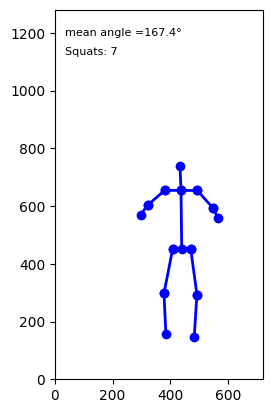

In [3]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots()
plt.gca().set_aspect('equal', adjustable='box')

ax.set_xlim(0, 720)
ax.set_ylim(0, 1280)

lines = [ax.plot([], [], 'bo-', lw=2)[0] for _ in connections]
angle_text = ax.text(0.3, 0.7, '', transform=ax.transAxes, color='black', fontsize=8, verticalalignment='top')
squat_text = ax.text(0.05, 0.85, '', transform=ax.transAxes, color='black', fontsize=8, verticalalignment='top')

def animate(i):
    """Update the animation with each frame."""
    frame = list_of_positions[i]
    for line, (start, end) in zip(lines, connections):
        x = [frame[start][0], frame[end][0]]
        y = [frame[start][1], frame[end][1]]
        line.set_data(x, y)

    if i < len(trace):
        current_angle = angles_mean[i]

        global squat_count, is_squatting
        if current_angle < ANGLE_THRESHOLD and not is_squatting:
            is_squatting = True
        elif current_angle > ANGLE_THRESHOLD and is_squatting:
            squat_count += 1
            is_squatting = False

    angle_text.set_text(f'mean angle ={round(current_angle, 1)}°')
    angle_text.set_position((0.05, 0.95))
    squat_text.set_text(f'Squats: {squat_count}')
    squat_text.set_position((0.05, 0.90))

    return lines 


# Create animation
ani = FuncAnimation(fig, animate, frames=len(list_of_positions), interval=100, blit=True)
# os.makedirs('Animations', exist_ok=True)
gif_path = 'Animations/'+json_file[5:-5] + '_animation.gif'
ani.save(gif_path, writer=PillowWriter(fps=30))

plt.show()

Text(0, 0.5, 'Angle [°]')

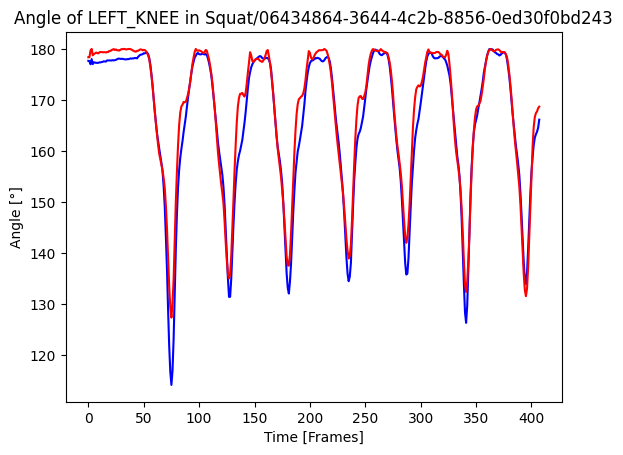

In [4]:
plt.title(f'Angle of LEFT_KNEE in {json_file[5:-5]}')
plt.plot(angles_lk, 'b')
plt.plot(angles_rk, 'r')
plt.xlabel('Time [Frames]')
plt.ylabel('Angle [°]')


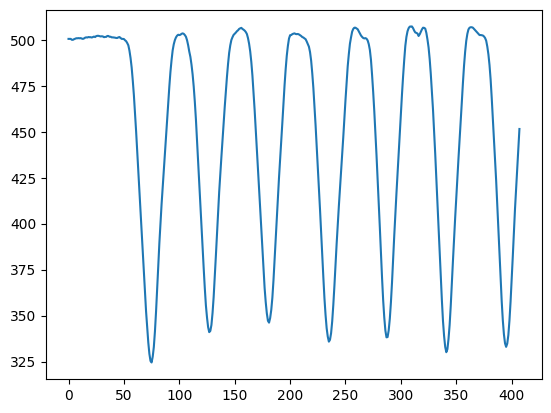

In [5]:

_, y = zip(*trace)
plt.plot(y)